# Prédiction de Rating de barres de chocolat

*Data Valorisation - Kaggle challenge*

---
#### Gille Cyprien

In [1]:
# Imports nécessaires
library(tfdatasets)
library(keras)
library(tidyverse) # pour make.names, type_convert...

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## 1. Preprocessing

In [2]:
# lecture du dataset
data_file_path = "../input/chocolate-bar-ratings/flavors_of_cacao.csv"
chocodata <- read.csv(data_file_path)

### Rappels

Notre dataset contient des barres de chocolat notées, ainsi que quelques-unes de leur caractéristiques (provenance, marque...).

Notre business goal est de fournir un modèle qui permet de **prédire le Rating** à partir des autres aspects d'une barre de chocolat, à des fins de simulation par les entreprises lors de la phase de R&D.

Notre technical goal est d'implémenter cette prédiction (tâche de régression) par un **réseau de neurones**. Le choix de cette solution se justifie par le fait que le lien entre les features et le rating est très complexe, et que des outils de régression plus rudimentaires ne sauraient l'exploiter.

On utilisera majoritairement la librairie **keras** (API de tensorflow pour R).

### 1.a Nettoyage

Certaines colonnes ont des noms avec des espaces. Par conséquent, pour pouvoir utiliser la syntaxe ```data$col_name```, on transforme tous les noms en chaînes de charactères valides.

On transforme également la colonne Cocoa.Percent depuis des valeurs telles que ```75%``` (string) en ```75``` (entier).

Enfin, on retire du dataset la colonne Bean.Type, car elle contient 47% de valeurs manquantes.

In [3]:
# transforme les noms des colonnes en noms valides pour R
names(chocodata) <- make.names(names(chocodata), unique=TRUE)

# pourcentage -> nombres
# on retire d'abord le charactère %
chocodata$Cocoa.Percent <- sapply(chocodata$Cocoa.Percent, function(x) gsub("%", "", x))
# convertit autant que possibe en types numériques ("75" devient 75 par exemple)
chocodata <- type_convert(chocodata)
                                  
# on retire Bean.Type (trop de missing values)
chocodata <- subset(chocodata, select = -Bean.Type)

# Dans certains environnements R le make.names échoue pour la col 1
# à cause d'un line break donc pour être sûrs, on le fait à la main
names(chocodata)[1] <- "Company...Maker.if.known."


── Column specification ────────────────────────────────────────────────────────
cols(
  Cocoa.Percent = col_double()
)




On effectue la même transformation en chaînes valides en R pour toutes les variables textuelles, afin de pouvoir les tokenizer plus loin.

In [4]:
# on se débarasse des espaces, des (, des )
chocodata$Company...Maker.if.known. <- make.names(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- make.names(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- make.names(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- make.names(chocodata$Broad.Bean.Origin)
head(chocodata, 10) # pour voir l'effet des changements

,Company...Maker.if.known.,Specific.Bean.Origin.or.Bar.Name,REF,Review.Date,Cocoa.Percent,Company.Location,Rating,Broad.Bean.Origin
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,A..Morin,Agua.Grande,1876,2016,63,France,3.75,Sao.Tome
2,A..Morin,Kpime,1676,2015,70,France,2.75,Togo
3,A..Morin,Atsane,1676,2015,70,France,3.00,Togo
4,A..Morin,Akata,1680,2015,70,France,3.50,Togo
5,A..Morin,Quilla,1704,2015,70,France,3.50,Peru
6,A..Morin,Carenero,1315,2014,70,France,2.75,Venezuela
7,A..Morin,Cuba,1315,2014,70,France,3.50,Cuba
8,A..Morin,Sur.del.Lago,1315,2014,70,France,3.50,Venezuela
9,A..Morin,Puerto.Cabello,1319,2014,70,France,3.75,Venezuela


On mélange les lignes dès maintenant, pour éviter que l'ordre joue une importantce.

In [5]:
# on mélange les rows
set.seed(612)
shuffled_rows_indices <- sample(nrow(chocodata))
chocodata <- chocodata[shuffled_rows_indices, ]

### 1.b Tokenization

Pour pouvoir traiter les noms en tant qu'input du réseau de neurones, il nous faut les encoder dans des entiers. Ce processus est en général appelé l'Embedding, mais on trouve également le terme tokenization. Pour rester cohérent avec le noms des fonctions keras, on utilisera "tokenization". Il existe de nombreuses façons de faire, mais nous effectuerons une tokenization naïve: associer à chaque mot un entier de façon unique.

In [6]:
# on crée les tokenizers qui vont transformer les noms en entiers
# on ne leur fait pas convertir le texte en minuscules,
# ni ignorer les caractères spéciaux (que des points dans notre cas)
tok_Company <- text_tokenizer(lower=FALSE, filter="")
tok_BeanOrig <- text_tokenizer(lower=FALSE, filter="")
tok_CompanyLoc <- text_tokenizer(lower=FALSE, filter="")
tok_BroadBean <- text_tokenizer(lower=FALSE, filter="")

In [7]:
# on fait apprendre aux tokenizers le vocabulaire nécessaire pour chaque colonne
fit_text_tokenizer(tok_Company, chocodata$Company...Maker.if.known.)
fit_text_tokenizer(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
fit_text_tokenizer(tok_CompanyLoc, chocodata$Company.Location)
fit_text_tokenizer(tok_BroadBean, chocodata$Broad.Bean.Origin)

In [8]:
# transforme les strings en listes d'entiers, mais chaque liste est de taille 1
# parce qu'on a pris le soin de transformer "hello world" en "hello.world" ce qui fait 1 mot
chocodata$Company...Maker.if.known. <- texts_to_sequences(tok_Company, chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- texts_to_sequences(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- texts_to_sequences(tok_CompanyLoc, chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- texts_to_sequences(tok_BroadBean, chocodata$Broad.Bean.Origin)

In [9]:
# du coup on transforme ('unlist') les listes de taille 1 en entiers ([1241] devient 1241)
chocodata$Company...Maker.if.known. <- unlist(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- unlist(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- unlist(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- unlist(chocodata$Broad.Bean.Origin)
head(chocodata) # voyons à quoi ressemblent les features tokenisées

,Company...Maker.if.known.,Specific.Bean.Origin.or.Bar.Name,REF,Review.Date,Cocoa.Percent,Company.Location,Rating,Broad.Bean.Origin
,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>
1760,215,183,1948,2017,70,1,2.75,4
212,177,184,256,2008,70,1,3.00,7
1524,1,69,1030,2013,70,3,3.25,24
1422,98,185,404,2009,75,13,2.75,12
397,61,4,1764,2016,60,1,3.00,5
1748,178,186,1912,2016,74,1,3.00,1


### 1.c Normalisation

Certaines valeurs ont des ordres de grandeur dans la centaine (ex: pourcentage), d'autres dans les milliers (ex: année). Pour éviter que les secondes écrasent les premières dans le réseau de neurones, on transforme toutes les features pour qu'elles aient **une moyenne de 0 et une variance de 1**.

On garde en réserve de quoi dé-scale le rating pour revenir entre 1 et 5 post-prédiction.

In [10]:
# Pour dé-scale le rating plus tard
rating_mean = mean(chocodata$Rating)
rating_sd = sd(chocodata$Rating)


# Centrer normer
for (feat in names(chocodata)) {
  chocodata[[feat]] <- c(scale(chocodata[[feat]]))
}

## 2. Réseau de Neurones

In [11]:
# features et target
# la feature REF ne porte pas d'information, on ne la garde donc pas
X = chocodata[ , c("Company...Maker.if.known.", 
                   "Specific.Bean.Origin.or.Bar.Name", 
                   "Review.Date", 
                   "Cocoa.Percent", 
                   "Company.Location", 
                   "Broad.Bean.Origin")]
Y = chocodata[ , c("Rating")]

Afin de pouvoir évaluer notre modèle sur des données qu'il n'aura pas vu pendant le training, on sépare notre dataset en training set et testing set (ou validation set - on a suffisament peu de données pour ne pas avoir à faire la différence)

In [12]:
# train/test sets
train_proportion = 0.8
splitter <- sample(c(rep(0, train_proportion * nrow(chocodata)), rep(1, (1 - train_proportion) * nrow(chocodata))))
x_train <- X[splitter == 0, ]   
x_test <- X[splitter == 1, ]
y_train <- Y[splitter ==0]
y_test <- Y[splitter ==1]

In [13]:
# conversion dataframe -> tf$Tensor
x_train <- tf$convert_to_tensor(x_train)
y_train <- tf$convert_to_tensor(y_train)
x_test <- tf$convert_to_tensor(x_test)
y_test <- tf$convert_to_tensor(y_test)

### 2.a Training

Notre tâche est une régression: on veut prédire un réél, le rating. Notre NN aura donc un seul neurone de sortie, prédisant ce chiffre. Quant au reste de l'architecture du réseau, on la choisit empiriquement en essayant différentes combinaisons, en trouvant l'équilibre entre un réseau trop peu large/profond pour remplir notre tâche complexe, et un réseau trop large qui transporterait les données dans des espaces de trop grande dimension.

In [14]:
# on définit l'architecture du modèle
model <- keras_model_sequential()
model %>%
  layer_dense(units = 6, activation="relu", input_shape = c(NULL,6)) %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 20, activation = 'relu') %>%
  layer_dense(units = 5, activation = 'relu') %>%
  layer_dense(units = 1)

L'optimiseur **RMSprop** est un optimiseur classique pour les cas de régression. Notre fonction de perte sera la **mean squared error**, également classique pour effectuer une régression. Ce sont également les choix menant aux meilleures performances parmi les optimizers et loss functions proposés par keras.

In [15]:
# on définit les paramètres d'entrainement du modèle
model %>% compile(
  optimizer = "RMSprop", 
  loss = "mse"
)

In [16]:
# on arrête l'entraînement lorsque val_loss n'a plus été améliorée depuis au moins [patience] epochs

 early_stop = callback_early_stopping(patience=60, 
                                      monitor = "val_loss", 
                                      mode = "min", 
                                      verbose = 1,
                                      restore_best_weights = TRUE)

# training
history <- fit(model, 
               x_train, 
               y_train, 
               epochs = 300, 
               verbose = 2, 
               validation_data = c(x_test, y_test), 
               callbacks = early_stop
)

In [17]:
losses <- history$metrics$loss
val_losses <- history$metrics$val_loss
n_epochs = length(losses)
cat("Loss à la fin du training : ", round(losses[n_epochs], 4), "\n")
cat("Validation Loss à la fin du training : ", round(val_losses[n_epochs], 4))

Loss à la fin du training :  0.7424 
Validation Loss à la fin du training :  0.9352

### 2.a Phase de test

In [18]:
## Fonctions utiles pour la prédiction

# inverser la normalisation sur le rating
descale <- function(r){
    return(r*rating_sd + rating_mean)
}

# obtenir la valeur i du test set (vraie valeur du rating)
get_real <- function(i){
  return(descale(k_get_value(y_test[i])))
  
}

# obtenir la valeur prédite par le modèle pour l'input i du test set
get_pred <- function(i){
  test <- k_reshape(x_test[i,], c(1,6))
  return(descale(predict(model, x=test)[1,]))
}

Pour se donner une idée des performances de notre modèle plus précise que "loss=0.75", on teste notre modèle sur des valeurs du test set.

In [19]:
# Comparons pour un i au hasard
# Vraie valeur
get_real(15)

[1] 2.5

In [20]:
# Valeur prédite
get_pred(15)

[1] 3.234447

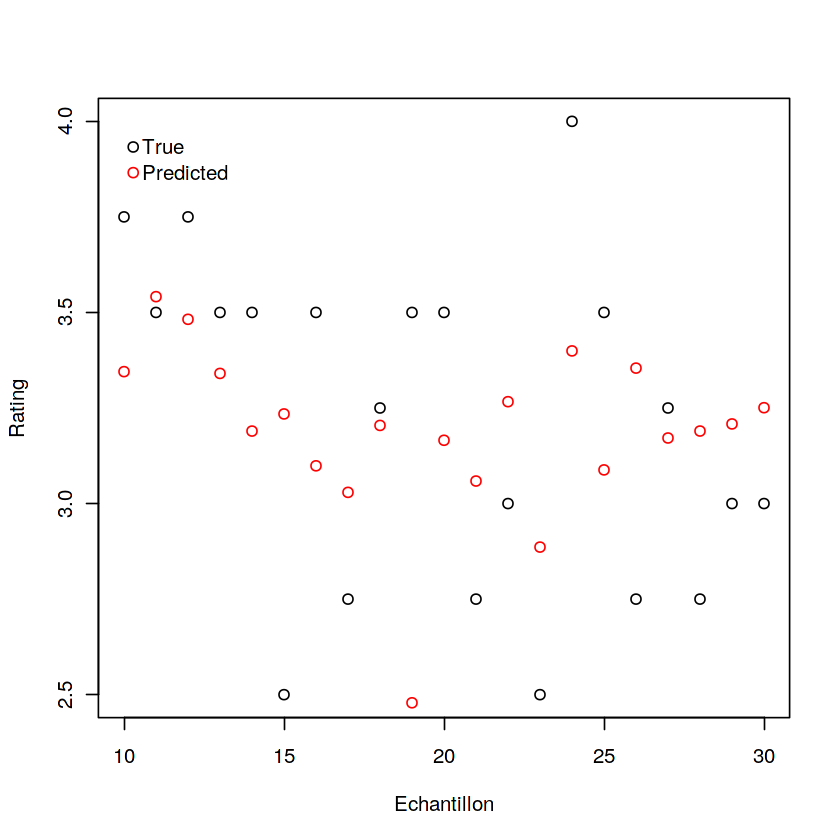

In [21]:
x <- 10:30
plot(x, map(x, get_real), col="black", ylab = "Rating", xlab = "Echantillon", pch=21)
points(x, map(x, get_pred), col="red", pch=21)
legend(x=10, y=4, legend = c("True", "Predicted"), pch=c(21, 21), col = c("black", "red"), bty="n")

On observe que notre réseau ne peut pas remplir le business goal: les prédictions sont trop erronées, et ce de façon quasiment aléatoire, pour qu'une entreprise puisse se reposer dessus. 

## 3. Le problème de la Tokenization

Cette barrière en termes de performance du modèle, qui se retrouve même si l'on entraîne un modèle plus large, ou plus profond, ou pendant plus longtemps, vient du fait que notre tokenization naïve perd totalement les proximités sémantiques de nos valeurs textuelles (4 des 6 features utilisées). 

In [22]:
# La france est plus proche des USA que d'Amsterdam
cat("France:", unlist(texts_to_sequences(tok_CompanyLoc, "France")), "\n")
cat("USA:", unlist(texts_to_sequences(tok_CompanyLoc, "U.S.A.")), "\n")
cat("Amsterdam:", unlist(texts_to_sequences(tok_CompanyLoc, "Amsterdam")))

France: 2 
USA: 1 
Amsterdam: 35

On voit par exemple que l'information géographique est perdue par la tokenization. Et encore, il s'agissait là d'une feature volontairement choisie à des fins d'examples, mais il est en général beaucoup plus difficile d'imaginer ce que serait une "bonne" tokenization.

Pour les companies par exemple, quand devraient deux companies être tokenizées en entiers proches? Quand leur taille est similaire? Leur chiffre d'affaire? Leur 'identité de marque', en imaginant que l'on puisse quantifier une telle donnée. Si un humain pourrait dire que les companies Lindt et Cote D'or sont 'proches' car similaires, c'est là une tâche bien plus compliquée (pour un humain comme pour une intelligence artificielle) à résoudre dans le cas général, sur des centaines de marques.

Régler le problème de la tokenization est bien au-delà des perspectives de ce projet. La tokenization intelligente ou la word vectorization est un sujet actuel de recherche en Natural Language Processing, et des deep neural networks sont même entraînés spécifiquement pour créer efficacement des embeddings textuels.

# Conclusion

**Le dataset Chocolate Bar Ratings ne se prête pas aisément à la prédiction d'un rating d'une barre à partir des autres features. Comme vu dans la première delivery, les quelques features numériques sont très peu corrélées entre elles. Quant aux features textuelles, leur utilisation dans une tâche de régression se heurte au défi complexe de l'embedding.**

**Malgré ces impasses, ce projet nous a beaucoup appris sur les réseaux de neuronnes, les différents paramètres sur lesquels jouer (optimiseurs, fonctions loss, largeur, profondeur, fonctions d'activation...), et l'importance de l'embedding dans le traitement des mots.**

## Annexe
### Classification
Nous avons essayé de passer d'une tâche de régression à une tâche de classification. L'idée étant que, au prix de la précision décimale sur le rating exact, nous pourrions simplifier la tâche au réseau de neurones. On arrondit donc les ratings à l'entier le plus proche. 

Ce changement nous a aussi permis d'utiliser la Cross Entropy en tant que loss function, et adam comme optimizer. 

Les changements dans le code déjà vu ci-dessus sont minimaux (5 neurones au lieu d'1 dans la dernière couche du réseau, changement des paramètres de la méthode compile()...). Le point de comparaison intéressant est **la phase de test**.

In [23]:
chocodata <- read.csv(data_file_path)

names(chocodata) <- make.names(names(chocodata), unique=TRUE)

chocodata$Cocoa.Percent <- sapply(chocodata$Cocoa.Percent, function(x) gsub("%", "", x))

chocodata <- type_convert(chocodata)

chocodata <- subset(chocodata, select = -Bean.Type)


chocodata$Company...Maker.if.known. <- make.names(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- make.names(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- make.names(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- make.names(chocodata$Broad.Bean.Origin)

set.seed(622)
shuffled_rows_indices <- sample(nrow(chocodata))
chocodata <- chocodata[shuffled_rows_indices, ]

tok_Company <- text_tokenizer(lower=FALSE, filter="")
tok_BeanOrig <- text_tokenizer(lower=FALSE, filter="")
tok_CompanyLoc <- text_tokenizer(lower=FALSE, filter="")
tok_BroadBean <- text_tokenizer(lower=FALSE, filter="")

fit_text_tokenizer(tok_Company, chocodata$Company...Maker.if.known.)
fit_text_tokenizer(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
fit_text_tokenizer(tok_CompanyLoc, chocodata$Company.Location)
fit_text_tokenizer(tok_BroadBean, chocodata$Broad.Bean.Origin)

chocodata$Company...Maker.if.known. <- texts_to_sequences(tok_Company, chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- texts_to_sequences(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- texts_to_sequences(tok_CompanyLoc, chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- texts_to_sequences(tok_BroadBean, chocodata$Broad.Bean.Origin)

chocodata$Company...Maker.if.known. <- unlist(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- unlist(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- unlist(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- unlist(chocodata$Broad.Bean.Origin)

### Différence ###
# On arrondit les ratings
to_class <- function(r) {
  return(round(r) - 1) # -1 parce que les indices commencent à 0 dans keras (donc classe 0 = Rating 1)
}

chocodata$Rating <- unlist(map(chocodata$Rating, to_class))

### Différence ###
# On ne scale pas le rating (puisqu'on veut le garder en tant qu'indice de classe)
for (feat in names(chocodata)) {
  if (feat != "Rating") {
    chocodata[[feat]] <- c(scale(chocodata[[feat]]))
  }
}




# Partie NN

X = chocodata[ , c("Company...Maker.if.known.", 
                   "Specific.Bean.Origin.or.Bar.Name", 
                   "Review.Date", 
                   "Cocoa.Percent", 
                   "Company.Location", 
                   "Broad.Bean.Origin")]
Y = chocodata[ , c("Rating")]


splitter <- sample(c(rep(0, 0.8 * nrow(chocodata)), rep(1, 0.2 * nrow(chocodata))))
x_train <- X[splitter == 0, ]   
x_test <- X[splitter == 1, ]
y_train <- Y[splitter ==0]
y_test <- Y[splitter ==1]


x_traine <- tf$convert_to_tensor(x_train)
y_traine <- tf$convert_to_tensor(y_train)
x_teste <- tf$convert_to_tensor(x_test)
y_teste <- tf$convert_to_tensor(y_test)

### Différence ###
# L'output layer a 5 neurones, un pour chaque classe
# Activation softmax pour obtenir des 'probabilités' d'appartenance
model <- keras_model_sequential()
model %>%
  layer_dense(units = 6, activation="relu", input_shape = c(NULL,6)) %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 20, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 5, activation = 'relu') %>%
  layer_dense(units = 5, activation = "softmax")


### Différence ###
# Paramètres classiques pour une classification
model %>% compile(
  optimizer = "adam", 
  loss = loss_sparse_categorical_crossentropy
)

### Différence ###
# La patience est bien plus courte, car le training est très rapide
 early_stop = callback_early_stopping(patience=10, 
                                      monitor = "val_loss", 
                                      mode = "min", 
                                      verbose = 1,
                                      restore_best_weights = TRUE)

history <- fit(model, 
               x_traine, 
               y_traine, 
               epochs = 100, 
               verbose = 2, 
               validation_data = c(x_teste, y_teste),
               callbacks = early_stop
)

### Différence ###
# Classe 0 = Rating 1,..., Classe 4 = Rating 5
get_real <- function(i){
  return(k_get_value(y_teste[i]) + 1)
}

### Différence ###
# argmax(predictions) donne la classe (pas besoin de +1 car les indices de R commencent bien à 1)
get_pred <- function(i){
  test <- k_reshape(x_teste[i,], c(1,6))
  pred <- (predict(model, x=test)[1,])
  return(which(pred == max(pred)))   
}


── Column specification ────────────────────────────────────────────────────────
cols(
  Cocoa.Percent = col_double()
)




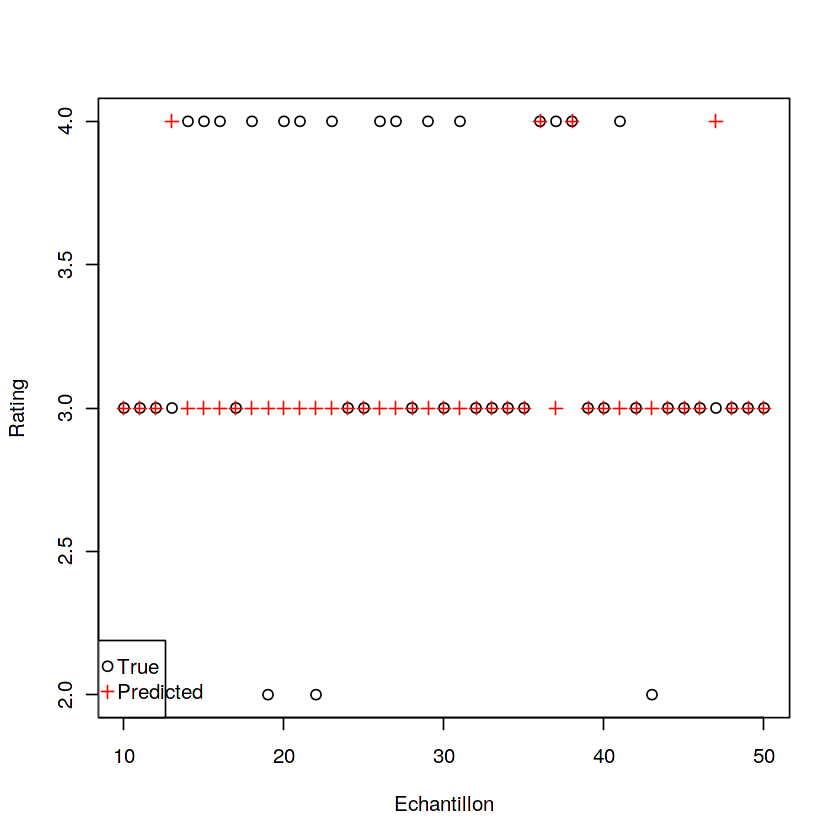

In [24]:
x <- 10:50
plot(x, map(x, get_real), col="black", ylab = "Rating", xlab = "Echantillon", pch=1)
points(x, map(x, get_pred), col="red", pch=3)
legend("bottomleft", legend = c("True", "Predicted"), pch=c(1, 3), col = c("black", "red"), bty="o")

On obtient des résultats qui peuvent sembler satisfaisants, mais la proportion de prédictions correctes n'est que de 57%. Le réseau prédit très souvent des 3, ce qui n'est pas surprenant: 

In [25]:
cat("Nombre de données : ", length(chocodata$Rating), "\n")
cat("Ratings 3 : ", length(which(chocodata$Rating == 2)), "\n") # Classe 2 = Rating 3

Nombre de données :  1795 
Ratings 3 :  903 


903 des 1795 données (50.3%) ont un rating arrondi à 3. C'est en partie en réponse à ce problème que l'on a exploré rapidement l'approche suivante.

### Equalization

Comme nous l'avions relevé dans la première delivery de ce projet, les ratings ne sont pas également répartis entre 1 et 5. Comme cela peut pousser les modèles à ne jamais prédire très loin d'environ 3, nous avons cherché une façon d'"étaler" les ratings avant l'entraînement., et de faire la transformation inverse après une prédiction. 

Nous avons testé la technique de l'[histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization). A des fins de clareté et de brièveté, nous ne rentrerons pas dans les détails de cette dernière, car elle n'a pas donné de résultats positifs.

La version du code avec cette equalization implémentée se trouve ci-dessous. Une fois de plus, le corps du code ne change quasiment pas, et la phase de test est la partie la plus parlante.

In [26]:
chocodata <- read.csv(data_file_path)

names(chocodata) <- make.names(names(chocodata), unique=TRUE)

chocodata$Cocoa.Percent <- sapply(chocodata$Cocoa.Percent, function(x) gsub("%", "", x))

chocodata <- type_convert(chocodata)

chocodata <- subset(chocodata, select = -Bean.Type)


chocodata$Company...Maker.if.known. <- make.names(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- make.names(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- make.names(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- make.names(chocodata$Broad.Bean.Origin)

set.seed(622)
shuffled_rows_indices <- sample(nrow(chocodata))
chocodata <- chocodata[shuffled_rows_indices, ]

tok_Company <- text_tokenizer(lower=FALSE, filter="")
tok_BeanOrig <- text_tokenizer(lower=FALSE, filter="")
tok_CompanyLoc <- text_tokenizer(lower=FALSE, filter="")
tok_BroadBean <- text_tokenizer(lower=FALSE, filter="")

fit_text_tokenizer(tok_Company, chocodata$Company...Maker.if.known.)
fit_text_tokenizer(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
fit_text_tokenizer(tok_CompanyLoc, chocodata$Company.Location)
fit_text_tokenizer(tok_BroadBean, chocodata$Broad.Bean.Origin)

chocodata$Company...Maker.if.known. <- texts_to_sequences(tok_Company, chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- texts_to_sequences(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- texts_to_sequences(tok_CompanyLoc, chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- texts_to_sequences(tok_BroadBean, chocodata$Broad.Bean.Origin)

chocodata$Company...Maker.if.known. <- unlist(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- unlist(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- unlist(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- unlist(chocodata$Broad.Bean.Origin)


── Column specification ────────────────────────────────────────────────────────
cols(
  Cocoa.Percent = col_double()
)




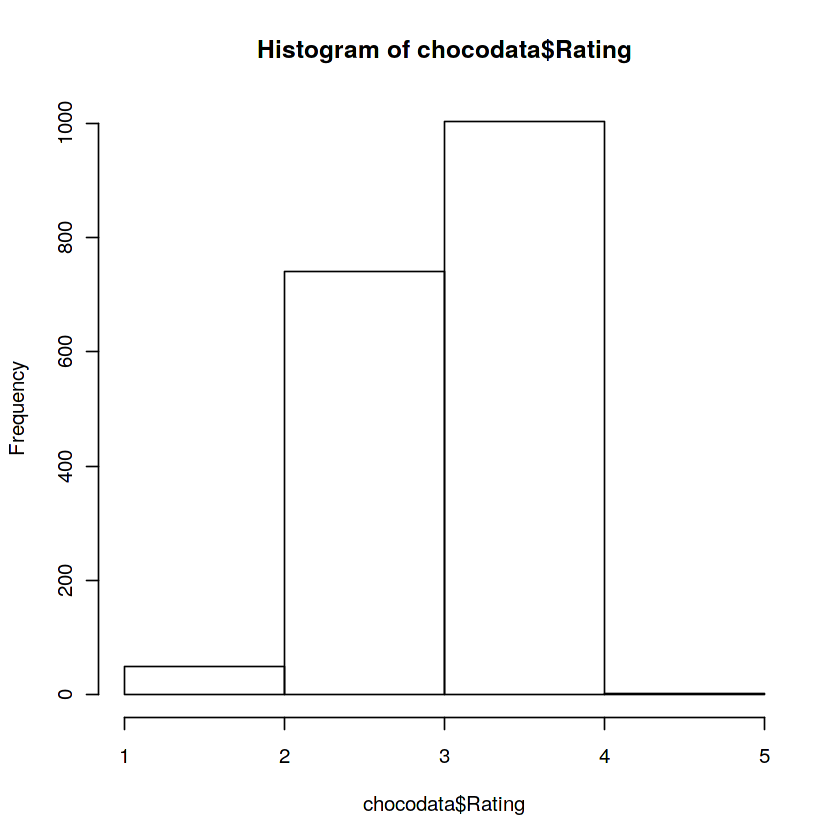

In [27]:
# Avant equalization
hist(chocodata$Rating, breaks=5)

In [28]:
# Equalization, cf lien wikipedia

true_ratings <- chocodata$Rating
n = nrow(chocodata)
rat_min <- min(true_ratings)
rat_max <- max(true_ratings)

equalize <- function(r){
  y <- length(which(true_ratings >= r))/n # cummulative distrib, mapped to 0,1
  return(y * (rat_max - rat_min) + rat_min) # mapping back to the original range
}

chocodata$Rating <- unlist(map(chocodata$Rating, equalize))

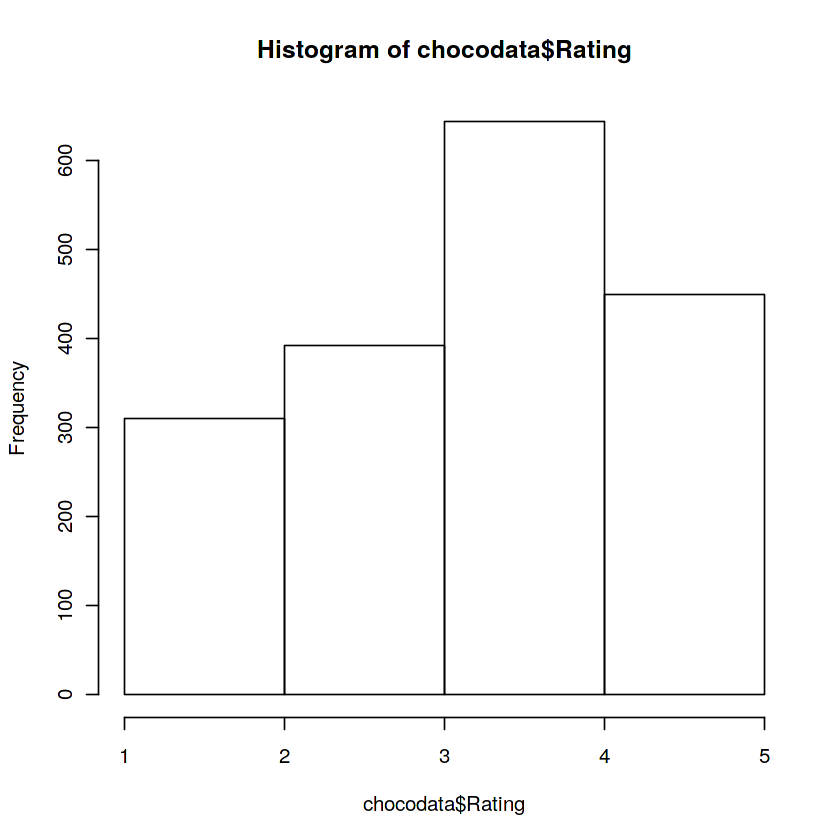

In [29]:
# Après Equalization
hist(chocodata$Rating, breaks=5)

In [30]:
for (feat in names(chocodata)) {
    chocodata[[feat]] <- c(scale(chocodata[[feat]]))
}




# Partie NN

X = chocodata[ , c("Company...Maker.if.known.", 
                   "Specific.Bean.Origin.or.Bar.Name", 
                   "Review.Date", 
                   "Cocoa.Percent", 
                   "Company.Location", 
                   "Broad.Bean.Origin")]
Y = chocodata[ , c("Rating")]


splitter <- sample(c(rep(0, 0.8 * nrow(chocodata)), rep(1, 0.2 * nrow(chocodata))))
x_train <- X[splitter == 0, ]   
x_test <- X[splitter == 1, ]
y_train <- Y[splitter ==0]
y_test <- Y[splitter ==1]


x_traine <- tf$convert_to_tensor(x_train)
y_traine <- tf$convert_to_tensor(y_train)
x_teste <- tf$convert_to_tensor(x_test)
y_teste <- tf$convert_to_tensor(y_test)


model <- keras_model_sequential()
model %>%
  layer_dense(units = 6, activation="relu", input_shape = c(NULL,6)) %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 20, activation = 'relu') %>%
  layer_dense(units = 5, activation = 'relu') %>%
  layer_dense(units = 1)


model %>% compile(
  optimizer = "RMSprop", 
  loss = "mse"
)

early_stop = callback_early_stopping(patience=60, 
                                     monitor = "val_loss", 
                                     mode = "min", 
                                     verbose = 1,
                                     restore_best_weights = TRUE)

history <- fit(model, 
               x_traine, 
               y_traine, 
               epochs = 300, 
               verbose = 2, 
               validation_data = c(x_teste, y_teste),
               callbacks = early_stop
)

# obtenir la valeur i du test set (vraie valeur du rating)
get_real <- function(i){
  return(k_get_value(y_test[i]))
  
}

# obtenir la valeur prédite par le modèle pour l'input i du test set
get_pred <- function(i){
  test <- k_reshape(x_test[i,], c(1,6))
  return(predict(model, x=test)[1,])
}

In [31]:
losses <- history$metrics$loss
val_losses <- history$metrics$val_loss
n_epochs = length(losses)
cat("Loss à la fin du training : ", round(losses[n_epochs], 4), "\n")
cat("Validation Loss à la fin du training : ", round(val_losses[n_epochs], 4))

Loss à la fin du training :  0.8103 
Validation Loss à la fin du training :  0.8665

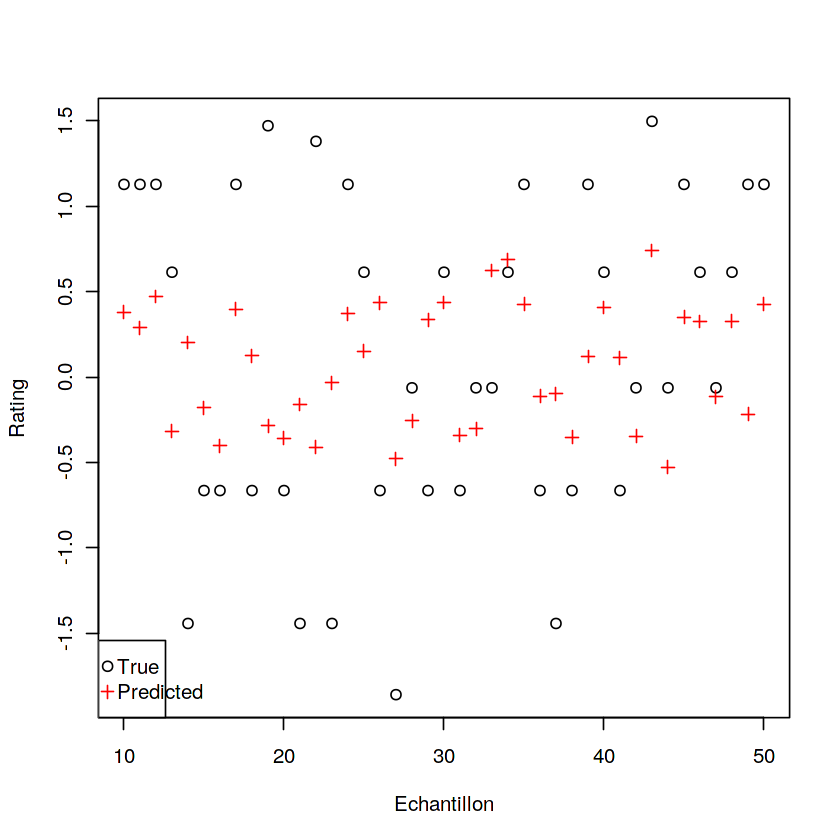

In [32]:
x <- 10:50
plot(x, map(x, get_real), col="black", ylab = "Rating", xlab = "Echantillon", pch=1)
points(x, map(x, get_pred), col="red", pch=3)
legend("bottomleft", legend = c("True", "Predicted"), pch=c(1, 3), col = c("black", "red"), bty="o")

On obtient des résultats moins bons que sans equalization. De plus, la transformation inverse n'est pas triviale à implémenter. On abandonne donc cette idée.